In [1]:
from jaxpinns.base import PINN
%load_ext autoreload
%autoreload 2
import jax
import jax.numpy as jnp
from jax.config import config
from scipy.linalg import eigh
config.update("jax_enable_x64", True)
from scipy.optimize import minimize
from pyDOE import lhs
import matplotlib.pyplot as plt
from matplotlib import rc
from functools import partial
from jax import random, grad, jit, vmap, jvp
from jax.ops import segment_sum
from jax.scipy.optimize import minimize
import numpy as np
import igl
from jaxpinns.samplers import Sampler
from jax.example_libraries import optimizers
from jaxpinns.architectures import MLP
from jaxpinns.optimizers import adam, momentum
from jaxpinns.loggers import logger
from torch.utils import data
from scipy.sparse.linalg import spsolve
rng_key = random.PRNGKey(0)
import time
import meshio
import pyvista as pv #requires python environment 3.7+
import tetgen
import sys
sys.path.append("utils")
from Mesh_tetra import Mesh
import os
from timeit import default_timer as timer

# To make graphs look better
import seaborn as sns
sns.set_theme()
import pandas as pd
from matplotlib.ticker import MultipleLocator
import csv

c:\Users\Rodrigo\anaconda3\envs\jaxgpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Mesh importation, eigenfunctions and B matrix computation

In [2]:
data_dense = pv.PolyData('S6_data/DENSE/S6_triangles.stl')

tet = tetgen.TetGen(data_dense)
tet.make_manifold()
tet.tetrahedralize(minratio = 1.0, mindihedral = 30)

heart_grid = tet.grid

# create Mesh object
connectivity_dense = heart_grid.cells_dict[10] # extract tetrahedra
points_dense       = heart_grid.points
centroids_dense    = points_dense[connectivity_dense].mean(1)

m = Mesh(verts = points_dense, connectivity = connectivity_dense)
m.writeVTU(filename = "S6_data/S6_80/S6_tetra.vtu")

print('Computing Laplacian')
K, M = m.computeLaplacian()

print('Computing eigen values')
eigvals, eigvecs = eigh(K,M)

m.writeVTU(filename = "S6_data/S6_80/heart3D_eigfuncs.vtu", scalars = {'v1': eigvecs[:,1], 'v10': eigvecs[:,10], 'v50': eigvecs[:,50], 'v60': eigvecs[:,60], 'v75': eigvecs[:,75], 'v100': eigvecs[:,100], 'v150': eigvecs[:,150], 'v200': eigvecs[:,200], 'v250': eigvecs[:,250], 'v300': eigvecs[:,300]})
n_eigs = 50

eigpairs = (jnp.array(eigvals[:n_eigs]), jnp.array(eigvecs[:,:n_eigs]).T)
eigfuncs = eigvecs[:,:n_eigs]

print("Number of mesh nodes:", points_dense.shape[0])
print("Number of mesh elements:", connectivity_dense.shape[0])
print("Eigenfunctions matrix shape:", eigfuncs.shape)

Computing Laplacian
Computing eigen values
Number of mesh nodes: 1702
Number of mesh elements: 6340
Eigenfunctions matrix shape: (1702, 50)


In [3]:
Bs = []
Ms = []

for e in range(m.connectivity.shape[0]):
    B, J = m.Bmatrix(e)
    Bs.append(B/J)
    Ms.append(J/2)


Bs = jnp.array(Bs)
Ms = jnp.array(Ms)

print("Bs shape:", Bs.shape)
print("Ms shape:", Ms.shape)

Bs shape: (6340, 3, 4)
Ms shape: (6340,)


Import DENSE displacement field:

In [4]:
def_mapping = np.genfromtxt('S6_data/DENSE/S6/S6.DENSE')
def_mapping = def_mapping.reshape((-1,3,def_mapping.shape[-1]))
def_mapping = np.transpose(def_mapping, [2, 0, 1])
print("Displacemente field shape:", def_mapping.shape) #Time frames corespond to shape[0] and [shape[1], shape[2]] corresponds to the cartesian coordinates of the points
print("Number of DENSE points:", def_mapping.shape[1])
print("Time frames:", def_mapping.shape[0])

Displacemente field shape: (35, 559, 3)
Number of DENSE points: 559
Time frames: 35


### Displacement field filtration

In [5]:
mid_mesh = pv.UnstructuredGrid({pv.CellType.TETRA:connectivity_dense}, points_dense)
mid_mesh['data'] = points_dense

def_points_0 = def_mapping[0,:,:] # time zero
mesh_points = pv.PolyData(def_points_0)
result = mesh_points.sample(mid_mesh)

mesh_points['error'] = np.linalg.norm(result['data'] - def_points_0, axis = 1)

Points that fall outside the LV mesh are removed.

In [6]:
error = np.linalg.norm(result['data'] - def_points_0, axis = 1)
tol = 1e-6
index_inside_points = np.squeeze(np.argwhere(error < tol))

In [7]:
end_time = def_mapping.shape[0]
time_line = jnp.arange(0, end_time, 1)

def inside(points, indices, time):
    def_points = points[time, :, :]
    return def_points[indices]

inside_fn = lambda x: inside(jnp.array(def_mapping), jnp.array(index_inside_points), x)
inside_mapping = np.squeeze(np.array(vmap(inside_fn)(time_line)))
print("Number of DENSE points that are inside the LV mesh:", inside_mapping.shape[1])

Number of DENSE points that are inside the LV mesh: 546


A relative displacement field respect reference configuration is needed.

In [8]:
u_0 = inside_mapping[0, :, :]
inside_def_mapping = inside_mapping - u_0

Eigenfunctions are interpolated to the mesh nodes.

In [9]:
eig_mesh = pv.UnstructuredGrid({pv.CellType.TETRA:connectivity_dense}, points_dense)
eig_mesh['eig'] = eigfuncs

def_points_eig = u_0 # time zero
mesh_points_eig = pv.PolyData(def_points_eig)
result_eig = mesh_points_eig.sample(eig_mesh)

inside_eigs = result_eig['eig']

And also are interpolated to the centroids of every LV mesh element.

In [10]:
eig_centr_mesh = pv.UnstructuredGrid({pv.CellType.TETRA:connectivity_dense}, points_dense)
eig_centr_mesh['eig'] = eigfuncs

mesh_points_eig_centr = pv.PolyData(centroids_dense)
result_eig_centr = mesh_points_eig_centr.sample(eig_centr_mesh)

centroids_eigs = result_eig_centr['eig']

Test and training set are created.

In [11]:
all_indices = np.arange(0, inside_def_mapping.shape[1], 1)
total_dots = all_indices.shape[0]
training_dots = int(total_dots*0.8)
rng_key=random.PRNGKey(1234)
key, subkey = random.split(rng_key)
idx_train = random.choice(subkey, all_indices, (training_dots,), replace = False)
idx_test = jnp.delete(all_indices, idx_train)

In [12]:
##Test set##

inside_mapping_test = inside_mapping[:, idx_test]
u_0_test = u_0[idx_test]
inside_def_mapping_test = inside_def_mapping[:, idx_test]
inside_eigs_test = inside_eigs[idx_test]

##Train set##

inside_mapping_train = inside_mapping[:, idx_train]
u_0_train = u_0[idx_train]
inside_def_mapping_train = inside_def_mapping[:, idx_train]
inside_eigs_train = inside_eigs[idx_train]

DENSE points that lay inside the LV mesh are exported to be plotted.

In [13]:
def_mapping_export = inside_mapping_test
for i in range(def_mapping_export.shape[0]):
    np.savetxt('S6_data/DENSE/DENSEpoints_80/pointstest_%i.csv' % i, def_mapping_export[i,:,:])

And also the relative displacement.

In [14]:
inside_to_plot = np.concatenate((inside_mapping_test, inside_def_mapping_test), axis = 2)
for i in range(inside_to_plot.shape[0]):
    np.savetxt('S6_data/DENSE/DENSEpoints_to_plot_80/points_toplot_%i.csv' % i, inside_to_plot[i,:,:])

## Importation of $\textbf{f}\otimes\textbf{f}$, $\textbf{l}\otimes\textbf{l}$, $\textbf{r}\otimes\textbf{r}$ and $\textbf{c}\otimes\textbf{c}$.

In [15]:
fxf_invivo_fibers = jnp.array(np.genfromtxt('S6_data/Obtain_Fiber_output/fxf_interpolated.csv')).reshape((-1, 3, 3))
cxc_invivo_fibers = jnp.array(np.genfromtxt('S6_data/Obtain_Fiber_output/cxc_interpolated.csv')).reshape((-1, 3, 3))
rxr_invivo_fibers = jnp.array(np.genfromtxt('S6_data/Obtain_Fiber_output/rxr_interpolated.csv')).reshape((-1, 3, 3))
lxl_invivo_fibers = jnp.array(np.genfromtxt('S6_data/Obtain_Fiber_output/lxl_interpolated.csv')).reshape((-1, 3, 3))

#Matrices are normalized by their trace.
fxf_trace_fn = lambda x: (1/jnp.trace(x))*x

fxf_invivo_fibers = vmap(fxf_trace_fn)(fxf_invivo_fibers)
cxc_invivo_fibers = vmap(fxf_trace_fn)(cxc_invivo_fibers)
rxr_invivo_fibers = vmap(fxf_trace_fn)(rxr_invivo_fibers)

# Neural Network definition

In [16]:
class FiberDense(PINN):
    # Initialize the class
    def __init__(self, eigfuncs, mu_X = 0.0, sigma_X = 1.0):
        super().__init__(mu_X, sigma_X)
        self.num_loss_terms = 3
        
        self.eigfuncs = eigfuncs

        self.mu = 1.0
        self.lamb = 1e3
        
        self.w_r = 4e-2
        self.w_u = 1.0
        self.w_theta = 1e-3
        
    def net_u(self, params, x):
    
        u = self.net_apply(params, x)
        return u

    @partial(jit, static_argnums=(0,))
    def W(self, F):
        C = jnp.matmul(F.T,F) 
        J = jnp.linalg.det(F)
        I1 = jnp.trace(C)
        C1 = self.mu
        D1 = self.lamb

        W = C1*(I1-3-jnp.log(J**2))+ D1*(J-1)**2
        return W

    @partial(jit, static_argnums=(0,))
    def preloss(self, params, batch, weights=(1.0,1.0)):

        inputs, _ = batch
        Vpc, _, _, _, _, _ = inputs
        # Evaluate model
        
        u_fn = lambda x: self.net_u(params, x)
        u_xyz = vmap(u_fn)(Vpc)

        ux = u_xyz[:,0]
        uy = u_xyz[:,1]
        uz = u_xyz[:,2]

        # Compute loss
        preloss = jnp.mean((ux)**2 + (uy)**2 + (uz)**2)
        return preloss
    
    @partial(jit, static_argnums=(0,))
    def loss_u(self, params, batch):

        inputs, u_t = batch
        _, def_eigs, _, _, _, _ = inputs

        # Evaluate model

        u_fn = lambda x: self.net_u(params, x)
        u_xyz = vmap(u_fn)(def_eigs)
        
        ux = u_xyz[:,0]
        uy = u_xyz[:,1]
        uz = u_xyz[:,2]

        ux_map = u_t[:,0]
        uy_map = u_t[:,1]
        uz_map = u_t[:,2]
      
        # Compute loss
        loss_u = jnp.mean((ux_map - ux)**2 + (uy_map - uy)**2 + (uz_map - uz)**2)
        return loss_u
    
    @partial(jit, static_argnums=(0,))
    def defgrad(self, Bs, u_e):
        return jnp.eye(3) + jnp.dot(Bs, u_e).T


    @partial(jit, static_argnums=(0,))
    def loss_r(self, params, batch):
       # Fetch data
        inputs, _ = batch
        #_, _, X_res, Bs, fibers, _ = inputs
        _, _, X_res, Bs, fxf, _ = inputs

        u_fn = lambda x: self.net_u(params, x)
        u_xyz = vmap(u_fn)(X_res)
        u_x = u_xyz[:,0].reshape((-1,4))
        u_y = u_xyz[:,1].reshape((-1,4))
        u_z = u_xyz[:,2].reshape((-1,4))
        theta = u_xyz[:,3].reshape((-1,4))
        
        theta_c = jnp.exp(theta.mean(1)) #to avoid weird negatives values
        theta_c = 1 - theta_c
        F_active_strain_fn = lambda x, y: jnp.eye(3) - (x/(1 - x))*y
        F_active_strain = vmap(F_active_strain_fn)(theta_c, fxf)

        u_e = jnp.stack((u_x, u_y, u_z), axis = 2)
        Fs = vmap(self.defgrad)(Bs, u_e)
        Fe_function = lambda x,y: jnp.matmul(x,y)
        Fe = vmap(Fe_function)(Fs, F_active_strain)

        #Evaluate residual
        res = vmap(self.W)(Fe)

        #rigid_body = jnp.mean((u_xyz)**2)
        #Compute loss
        loss_r = jnp.mean(res)#+ self.w_rigid*rigid_body
        return loss_r
    
    @partial(jit, static_argnums=(0,))
    def E(self, params, Bs, eigs_tetra, fxf):
        # Fetch data
        u_fn = lambda x: self.net_u(params, x)
        u_xyz = vmap(u_fn)(eigs_tetra)
        u_x = u_xyz[:,0].reshape((-1,4))
        u_y = u_xyz[:,1].reshape((-1,4))
        u_z = u_xyz[:,2].reshape((-1,4))

        u_e = jnp.stack((u_x, u_y, u_z), axis = 2)
        F = vmap(self.defgrad)(Bs, u_e)
        C_fn = lambda x: jnp.matmul(x.T, x)
        C = vmap(C_fn)(F)
        E_fn = lambda x, y: 0.5*(jnp.tensordot(x, y) - 1)
        E_direction = vmap(E_fn)(C, fxf)
        return E_direction


    @partial(jit, static_argnums=(0,))
    def loss_theta(self, params, batch):
        # Fetch data
        inputs, _ = batch
        _, _, X_res, _, _, _ = inputs
        theta_fn = lambda x: self.net_u(params, x)[3]
        theta_V_fn = grad(theta_fn)
        theta_V = vmap(theta_V_fn)(X_res) 
        loss_theta = jnp.mean(jnp.linalg.norm(theta_V, axis = 1)**2)
        return loss_theta


    @partial(jit, static_argnums=(0,))
    def loss(self, params, batch, weights=(1.0,1.0)):
        loss_u = self.loss_u(params, batch)
        loss_r = self.loss_r(params, batch)
        loss_theta = self.loss_theta(params, batch)
        loss = self.w_r*loss_r + self.w_u*loss_u + self.w_theta*loss_theta
        return loss

    # Evaluates predictions at test point
  
    @partial(jit, static_argnums=(0,))
    def predict(self, params, X_star):
        u_fn = lambda x: self.net_u(params, x)
        u_star = vmap(u_fn)(X_star)
        ux_star = u_star[:,0] 
        uy_star = u_star[:,1]
        uz_star = u_star[:,2]
        theta_star = u_star[:,3]
        return ux_star, uy_star, uz_star, theta_star

        
class image2DGenerator(data.Dataset):
    def __init__(self, eigenfuncs, grad_operator, jacobian, connectivity, u_maps, inside_eigfuncs, fxf, batch_size,
                 mu_X = 0.0, sigma_X = 1.0, rng_key=random.PRNGKey(1234)):
        'Initialization'

        self.V = jnp.array(eigenfuncs)
        self.grad_operator = jnp.array(grad_operator) #numerical gradient
        self.connectivity = jnp.array(connectivity)
        self.J = jnp.array(jacobian)
        self.u_maps = jnp.array(u_maps)
        self.inside_eigfuncs = jnp.array(inside_eigfuncs)
        self.fxf = fxf
        self.mu_X = mu_X
        self.sigma_X = sigma_X
        self.batch_size = batch_size
        self.key = rng_key
        self.n_frames = self.u_maps.shape[0]
        self.idx_t = 0

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        self.idx_t = (self.idx_t + 1) % self.n_frames
        X, y = self.__data_generation(subkey, self.idx_t)
        return X, y

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key, idx_t):
        'Generates data containing batch_size samples'
        
        idx_e = random.choice(key, self.grad_operator.shape[0], (self.batch_size,), replace = False)
        t = idx_t/self.n_frames

        Vc = self.V[jnp.ravel(self.connectivity[idx_e]),:]
        fibers_matrix = self.fxf[idx_e]

        Vtc = jnp.concatenate((Vc, jnp.ones((Vc.shape[0],1))*t), axis = 1)
        u_idx_t = self.u_maps[idx_t]
        Vpc = jnp.concatenate((self.V, jnp.ones((self.V.shape[0],1))*t), axis = 1)
        def_eigs = jnp.concatenate((self.inside_eigfuncs, jnp.ones((self.inside_eigfuncs.shape[0],1))*t), axis = 1)

        # Construct batch
        inputs  = (Vpc, def_eigs, Vtc, self.grad_operator[idx_e], fibers_matrix, self.J[idx_e])
        outputs = u_idx_t

        return inputs, outputs

## Preloss Training

In [17]:
init_key = random.PRNGKey(0)
n_depth = 2**5
layers = [n_eigs + 1, n_depth, n_depth, n_depth, n_depth, 4]
args = (layers,)
model = FiberDense(eigfuncs)
model.architecture(MLP, *args, init_key=init_key)

In [18]:
io_keys = ['loss_u', 'preloss', 'loss_r', 'loss_theta']
log_keys = ['loss_u','preloss', 'loss_r', 'loss_theta']
log_funs = [model.loss_u, model.preloss, model.loss_r, model.loss_theta]
args = (io_keys, log_keys, log_funs)
model.logger(logger, *args, io_step = 50)

In [19]:
batch_size = int(0.01*eigfuncs.shape[0])
dataset = image2DGenerator(eigfuncs, Bs, Ms, connectivity_dense, inside_def_mapping_train, inside_eigs_train, fxf_invivo_fibers, batch_size)

In [20]:
#Método de Adam:
learning_rate = 1e-2
args = (learning_rate, model.preloss)
model.optimizer(adam, *args)

In [21]:
n_iter_preloss = (963 + 1)*50
start_preloss = timer()
model.train(dataset, nIter = n_iter_preloss, ntk_weights=False)
preloss_params = model.get_params(model.opt_state)
end_preloss = timer()
time_preloss = end_preloss - start_preloss

  0%|          | 0/48200 [00:00<?, ?it/s]

100%|██████████| 48200/48200 [00:55<00:00, 864.61it/s, loss_u=3.5489701122485453, preloss=6.431391438203044e-17, loss_r=2345.8809289670057, loss_theta=5.378470991541297e-13]    


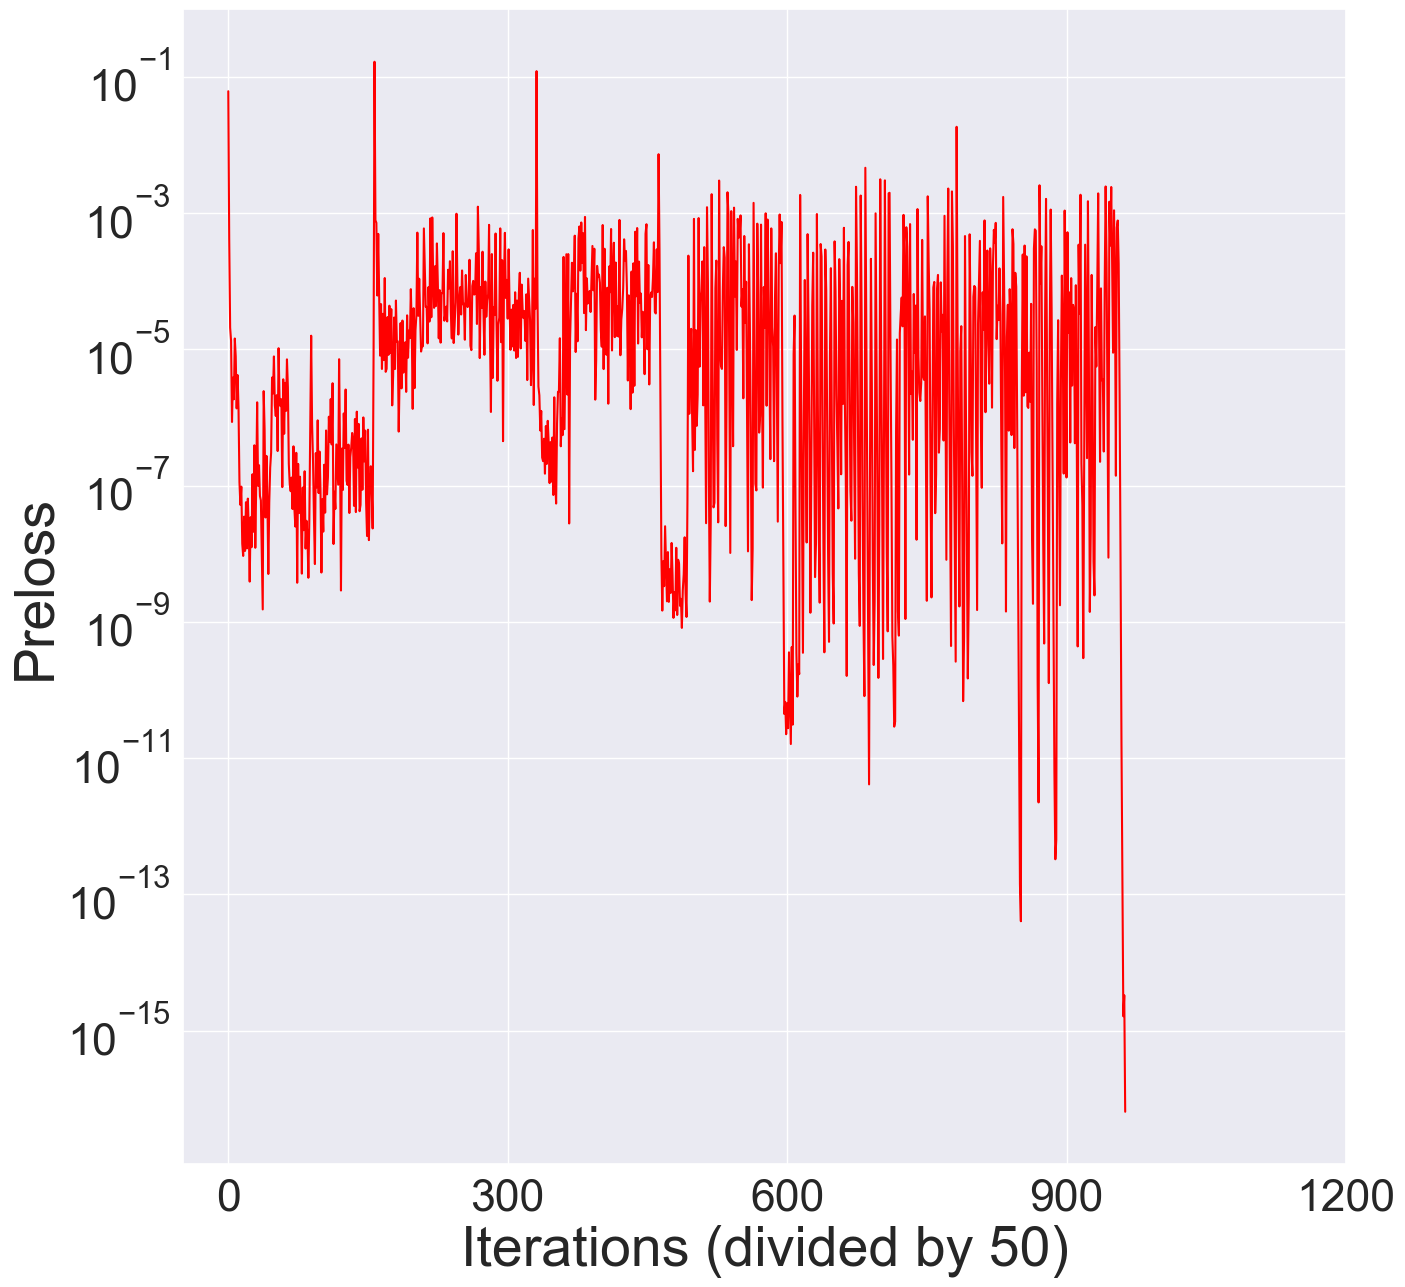

In [22]:
fig = plt.figure()
plt.plot(model.training_log['preloss'], color = 'red', label = 'preloss')
#plt.legend()
plt.yscale('log')
#plt.xticks(np.arange(0, (n_iter_preloss)/50 + 1, 1))
#plt.xticks(np.arange(0, (n_iter_preloss)/50 + 50, 50))
plt.xticks(np.arange(0, (n_iter_preloss)/50 + 300, 300))
plt.ylabel("Preloss", fontsize = 40)
plt.xlabel("Iterations (divided by 50)", fontsize = 40)
fig.set_size_inches((15,15))
#plt.xlim(950, 980)
plt.xticks(fontsize=32)  # for x-axis
plt.yticks(fontsize=32)
plt.savefig('S6_data/S6_80/Preloss.png')

In [23]:
for i in range(dataset.n_frames):
    t = i/dataset.n_frames

    #The displacement field is computed first over the entire mesh to know how it deforms.
    u_pred_preloss = model.predict(preloss_params, jnp.concatenate((model.eigfuncs, jnp.ones((model.eigfuncs.shape[0],1))*t), axis = 1))

    ux_pred_preloss = u_pred_preloss[0]
    uy_pred_preloss = u_pred_preloss[1]
    uz_pred_preloss = u_pred_preloss[2]
    theta_pred_preloss = u_pred_preloss[3]

    u_preloss = np.concatenate(([ux_pred_preloss], [uy_pred_preloss], [uz_pred_preloss]), axis = 0).T

    points_preloss = points_dense + u_preloss
    mesh_preloss = Mesh(verts = points_preloss, connectivity = connectivity_dense)

    #Average displacemente fields.
    u_field_mean_preloss = jnp.mean(u_preloss, axis = 1)
    u_mean_preloss = jnp.sqrt(jnp.mean((ux_pred_preloss), axis = 0)**2 + jnp.mean((uy_pred_preloss), axis = 0)**2 + jnp.mean((uz_pred_preloss), axis = 0)**2)

    ux_max_preloss = jnp.max(ux_pred_preloss)
    uy_max_preloss = jnp.max(uy_pred_preloss)
    uz_max_preloss = jnp.max(uz_pred_preloss)
    u_vec_max_preloss = jnp.array([ux_max_preloss, uy_max_preloss, uz_max_preloss])
    u_max_preloss = u_vec_max_preloss.max()

    ux_min_preloss = jnp.min(ux_pred_preloss)
    uy_min_preloss = jnp.min(uy_pred_preloss)
    uz_min_preloss = jnp.min(uz_pred_preloss)
    u_vec_min_preloss = jnp.array([ux_min_preloss, uy_min_preloss, uz_min_preloss])
    u_min_preloss = u_vec_min_preloss.min()

    #Now the displacement field is computed on the DENSE points inside the mesh to compare outcomes.

    u_inner_preloss = model.predict(preloss_params, jnp.concatenate((inside_eigs, jnp.ones((inside_eigs.shape[0],1))*t), axis = 1))

    ux_inner_preloss = u_inner_preloss[0]
    uy_inner_preloss = u_inner_preloss[1]
    uz_inner_preloss = u_inner_preloss[2]
    theta_inner_preloss = u_inner_preloss[3]

    u_preloss_in = np.concatenate(([ux_inner_preloss], [uy_inner_preloss], [uz_inner_preloss]), axis = 0).T

    points_preloss_in = u_0 + u_preloss_in

    #Average displacemente fields.
    u_field_mean_preloss_in = jnp.mean(u_preloss_in, axis = 1)
    u_mean_preloss_in = jnp.sqrt(jnp.mean((ux_inner_preloss), axis = 0)**2 + jnp.mean((uy_inner_preloss), axis = 0)**2 + jnp.mean((uz_inner_preloss), axis = 0)**2)

    ux_max_preloss_in = jnp.max(ux_inner_preloss)
    uy_max_preloss_in = jnp.max(uy_inner_preloss)
    uz_max_preloss_in = jnp.max(uz_inner_preloss)
    u_vec_max_preloss_in = jnp.array([ux_max_preloss_in, uy_max_preloss_in, uz_max_preloss_in])
    u_max_preloss_in = u_vec_max_preloss_in.max()

    ux_min_preloss_in = jnp.min(ux_inner_preloss)
    uy_min_preloss_in = jnp.min(uy_inner_preloss)
    uz_min_preloss_in = jnp.min(uz_inner_preloss)
    u_vec_min_preloss_in = jnp.array([ux_min_preloss_in, uy_min_preloss_in, uz_min_preloss_in])
    u_min_preloss_in = u_vec_min_preloss_in.min()

    error_preloss = np.linalg.norm(np.abs((points_preloss_in - u_0)), axis = 1)
    max_error_preloss = error_preloss.max()
    
    print("Tiempo %i: u_prom:" %i,u_mean_preloss_in, "u_max:", u_max_preloss_in, "u_min:", u_min_preloss_in, "max_error:", max_error_preloss)    

Tiempo 0: u_prom: 6.787244267662015e-08 u_max: 2.3646115676623225e-08 u_min: -8.841378140722611e-08 max_error: 9.157185727480572e-08
Tiempo 1: u_prom: 7.018947460182277e-08 u_max: 2.459546027955284e-08 u_min: -8.909751894603524e-08 max_error: 9.249103413201364e-08
Tiempo 2: u_prom: 7.25087464498469e-08 u_max: 2.5467910558241158e-08 u_min: -8.9725878171798e-08 max_error: 9.334164850688541e-08
Tiempo 3: u_prom: 7.47880561746113e-08 u_max: 2.626962725127413e-08 u_min: -9.030329703452189e-08 max_error: 9.412813877092831e-08
Tiempo 4: u_prom: 7.700026917287008e-08 u_max: 2.700613660477913e-08 u_min: -9.083375751561817e-08 max_error: 9.485464591698117e-08
Tiempo 5: u_prom: 7.912861456994188e-08 u_max: 2.7682404202256095e-08 u_min: -9.132083714225026e-08 max_error: 9.552501621732818e-08
Tiempo 6: u_prom: 8.116340937215717e-08 u_max: 2.8302898413823385e-08 u_min: -9.176775525587821e-08 max_error: 9.614281189025311e-08
Tiempo 7: u_prom: 8.309979558598752e-08 u_max: 2.8871645962880166e-08 u_min:

## Loss Training

In [24]:
init_key = random.PRNGKey(0)
args1 = (layers,)
model = FiberDense(eigfuncs)
model.architecture(MLP, *args1, init_key=init_key)

In [25]:
io_keys  = ['loss', 'loss_u', 'loss_r', 'loss_theta']
log_keys = ['loss', 'loss_u', 'loss_r', 'loss_theta']
log_funs = [model.loss, model.loss_u, model.loss_r, model.loss_theta]
args = (io_keys, log_keys, log_funs)
model.logger(logger, *args, io_step = 50)

In [26]:
model.net_params= preloss_params

#Adam optimizer.
learning_rate1 = optimizers.exponential_decay(1e-3, decay_steps=2000, decay_rate=0.9)#2000 decay_steps at least to get better results.
args1 = (learning_rate1, model.loss)
model.optimizer(adam, *args1)

In [27]:
n_iter_loss = 300000
start_loss = timer()
model.train(dataset, nIter = n_iter_loss, ntk_weights=False)
loss_params = model.get_params(model.opt_state)
end_loss = timer()
time_loss = end_loss - start_loss

100%|██████████| 300000/300000 [07:19<00:00, 682.38it/s, loss=0.036631910632571485, loss_u=0.03128926495870176, loss_r=0.12360246092109098, loss_theta=0.39854723702608497]   


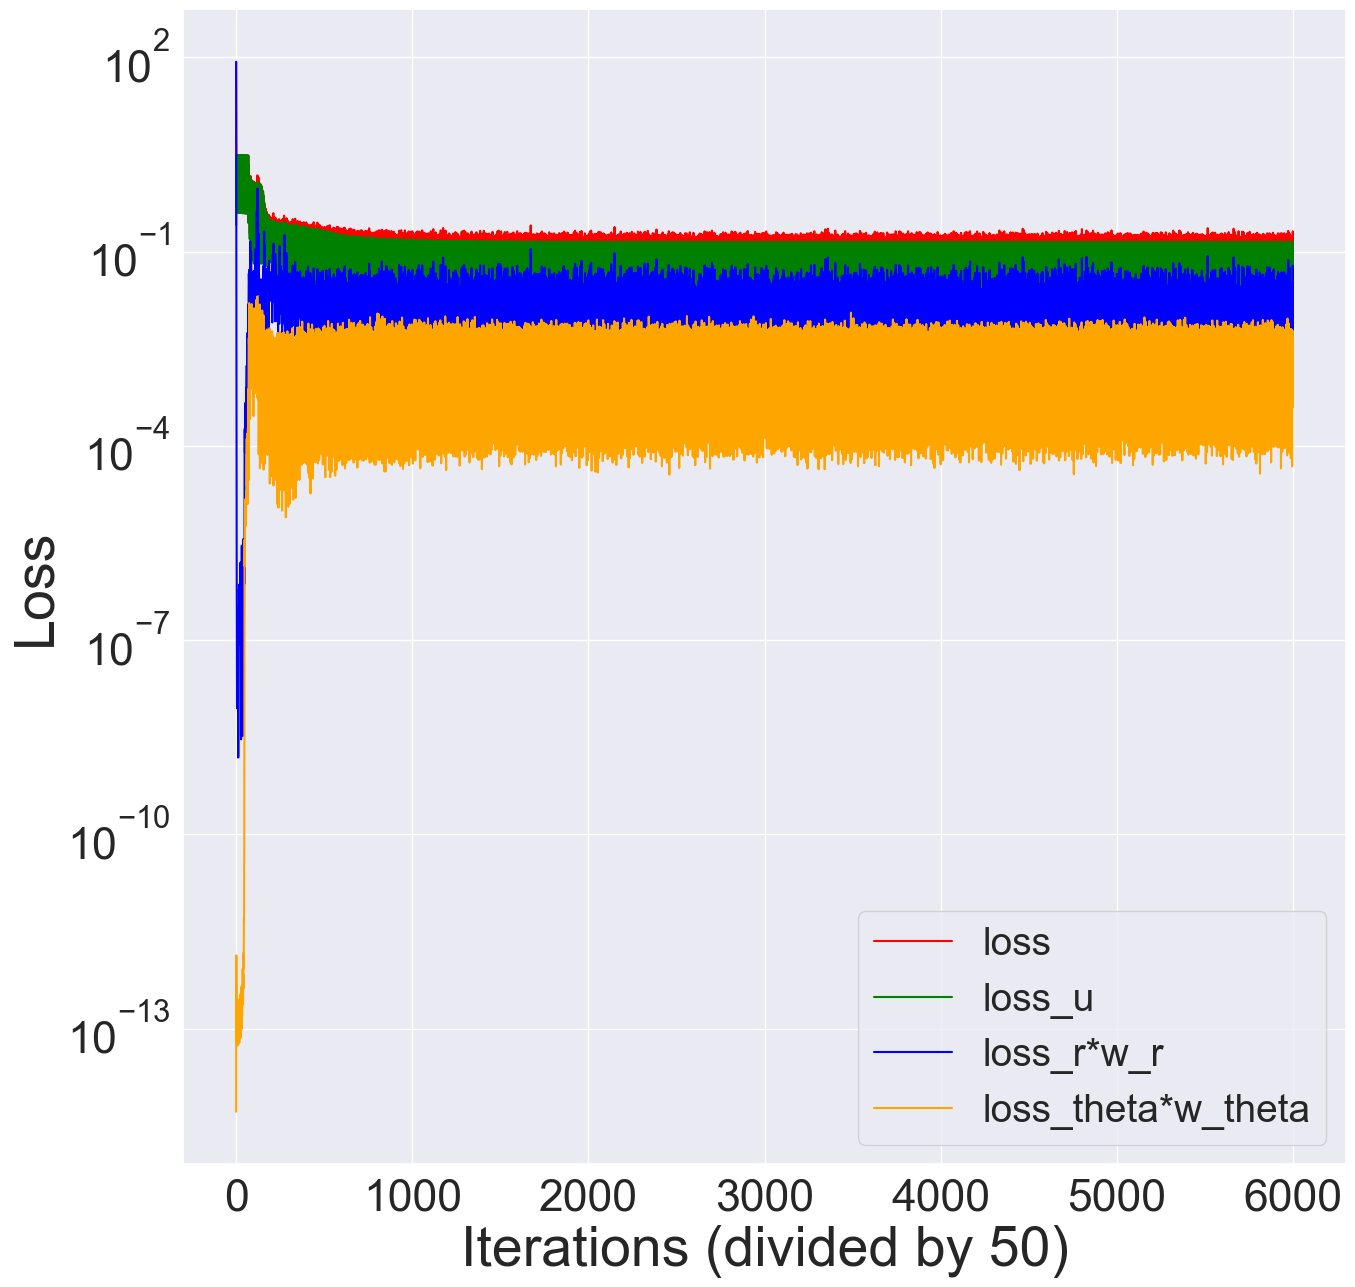

In [28]:
fig = plt.figure()
fig.set_size_inches((15,15))
plt.plot(model.training_log['loss'], color = 'red', label = 'loss')
plt.plot(model.training_log['loss_u'], color = 'green', label = 'loss_u')
plt.plot(jnp.array(model.training_log['loss_r'])*model.w_r, color = 'blue', label = 'loss_r*w_r')
plt.plot(jnp.array(model.training_log['loss_theta'])*model.w_theta, color = 'orange', label = 'loss_theta*w_theta')
plt.legend()
plt.yscale('log')
plt.xlabel("Iterations (divided by 50)", fontsize = 40)
plt.ylabel("Loss", fontsize = 40)
plt.xticks(fontsize=32)  # for x-axis
plt.yticks(fontsize=32)
plt.legend(fontsize = 28)
plt.savefig('S6_data/S6_80/Loss.png')

In [29]:
with open("S6_data/S6_80/Information_loss.txt",'w') as f:
    pass
max_error_to_plot = []
min_error_to_plot = []
mean_error_to_plot = []
all_error = []
all_error_test = []
max_error_to_plot_test = []
min_error_to_plot_test = []
mean_error_to_plot_test = []

for i in range(dataset.n_frames):
    t = i/dataset.n_frames

    #The displacement field is computed first over the entire mesh to know how it deforms.
    u_pred_loss = model.predict(loss_params, jnp.concatenate((model.eigfuncs, jnp.ones((model.eigfuncs.shape[0],1))*t), axis = 1))

    ux_pred_loss = u_pred_loss[0]
    uy_pred_loss = u_pred_loss[1]
    uz_pred_loss = u_pred_loss[2]
    theta_pred_loss = u_pred_loss[3]
    np.savetxt('S6_data/S6_80/Theta_Loss/loss_theta_%i.csv' % i, theta_pred_loss)

    u_loss = np.concatenate(([ux_pred_loss], [uy_pred_loss], [uz_pred_loss]), axis = 0).T

    points_loss = points_dense + u_loss
    mesh_loss = Mesh(verts = points_loss, connectivity = connectivity_dense)

    #Average displacemente fields.
    u_field_mean_loss = jnp.mean(u_loss, axis = 1)
    u_mean_loss = jnp.sqrt(jnp.mean((ux_pred_loss), axis = 0)**2 + jnp.mean((uy_pred_loss), axis = 0)**2 + jnp.mean((uz_pred_loss), axis = 0)**2)

    ux_max_loss = jnp.max(ux_pred_loss)
    uy_max_loss = jnp.max(uy_pred_loss)
    uz_max_loss = jnp.max(uz_pred_loss)
    u_vec_max_loss = jnp.array([ux_max_loss, uy_max_loss, uz_max_loss])
    u_max_loss = u_vec_max_loss.max()

    ux_min_loss = jnp.min(ux_pred_loss)
    uy_min_loss = jnp.min(uy_pred_loss)
    uz_min_loss = jnp.min(uz_pred_loss)
    u_vec_min_loss = jnp.array([ux_min_loss, uy_min_loss, uz_min_loss])
    u_min_loss = u_vec_min_loss.min()

    
    #Strain tensors are saved to plot over the centroid of the LV mesh.
    
    e_ff_mesh = model.E(loss_params, Bs, jnp.concatenate((eigfuncs[jnp.ravel(connectivity_dense)], jnp.ones((eigfuncs[jnp.ravel(connectivity_dense)].shape[0],1))*t), axis = 1), fxf_invivo_fibers)
    e_cc_mesh = model.E(loss_params, Bs, jnp.concatenate((eigfuncs[jnp.ravel(connectivity_dense)], jnp.ones((eigfuncs[jnp.ravel(connectivity_dense)].shape[0],1))*t), axis = 1), cxc_invivo_fibers)
    e_rr_mesh = model.E(loss_params, Bs, jnp.concatenate((eigfuncs[jnp.ravel(connectivity_dense)], jnp.ones((eigfuncs[jnp.ravel(connectivity_dense)].shape[0],1))*t), axis = 1), rxr_invivo_fibers)
    e_ll_mesh = model.E(loss_params, Bs, jnp.concatenate((eigfuncs[jnp.ravel(connectivity_dense)], jnp.ones((eigfuncs[jnp.ravel(connectivity_dense)].shape[0],1))*t), axis = 1), lxl_invivo_fibers)

    E_mesh = pv.PolyData(centroids_dense)
    E_mesh['e_ff'] = e_ff_mesh
    E_mesh['e_ll'] = e_ll_mesh
    E_mesh['e_rr'] = e_rr_mesh
    E_mesh['e_cc'] = e_cc_mesh
    mesh_points_E = pv.UnstructuredGrid({pv.CellType.TETRA:connectivity_dense}, points_dense)
    result_E = mesh_points_E.interpolate(E_mesh)
    E_ff = result_E['e_ff']
    E_ll = result_E['e_ll']
    E_rr = result_E['e_rr']
    E_cc = result_E['e_cc']

    mesh_loss.writeVTU("S6_data/S6_80/Loss/u_loss_%i.vtu" %i, scalars = {"u_mean": u_field_mean_loss, "u_x": ux_pred_loss, "u_y": uy_pred_loss, "u_z": uz_pred_loss, "theta": theta_pred_loss, "E_ff": E_ff, "E_ll": E_ll, "E_rr": E_rr, "E_cc": E_cc})



    #Now the displacement field is computed on the DENSE test points.

    u_inner_loss_test = model.predict(loss_params, jnp.concatenate((inside_eigs_test, jnp.ones((inside_eigs_test.shape[0],1))*t), axis = 1))

    ux_inner_loss_test = u_inner_loss_test[0]
    uy_inner_loss_test = u_inner_loss_test[1]
    uz_inner_loss_test = u_inner_loss_test[2]
    theta_inner_loss_test = u_inner_loss_test[3]

    u_loss_in_test = np.concatenate(([ux_inner_loss_test], [uy_inner_loss_test], [uz_inner_loss_test]), axis = 0).T

    points_loss_in_test = u_0_test + u_loss_in_test
    np.savetxt('S6_data/S6_80/Points_Loss_Test/points_loss_%i.csv' % i, points_loss_in_test)

    relative_u_loss_test =np.concatenate((points_loss_in_test, u_loss_in_test), axis = 1)
    np.savetxt('S6_data/S6_80/Relative_Def_Test/points_loss_%i.csv' % i, relative_u_loss_test)

    #Average displacemente fields.
    u_field_mean_loss_in_test = jnp.mean(u_loss_in_test, axis = 1)
    u_mean_loss_in_test = jnp.sqrt(jnp.mean((ux_inner_loss_test), axis = 0)**2 + jnp.mean((uy_inner_loss_test), axis = 0)**2 + jnp.mean((uz_inner_loss_test), axis = 0)**2)

    ux_max_loss_in_test = jnp.max(ux_inner_loss_test)
    uy_max_loss_in_test = jnp.max(uy_inner_loss_test)
    uz_max_loss_in_test = jnp.max(uz_inner_loss_test)
    u_vec_max_loss_in_test = jnp.array([ux_max_loss_in_test, uy_max_loss_in_test, uz_max_loss_in_test])
    u_max_loss_in_test = u_vec_max_loss_in_test.max()

    ux_min_loss_in_test = jnp.min(ux_inner_loss_test)
    uy_min_loss_in_test = jnp.min(uy_inner_loss_test)
    uz_min_loss_in_test = jnp.min(uz_inner_loss_test)
    u_vec_min_loss_in_test = jnp.array([ux_min_loss_in_test, uy_min_loss_in_test, uz_min_loss_in_test])
    u_min_loss_in_test = u_vec_min_loss_in_test.min()

    error_loss_test = np.linalg.norm(points_loss_in_test - inside_mapping_test[i, :, :], axis = 1)
    error_loss_test_to_plot =np.concatenate((points_loss_in_test, jnp.array([error_loss_test]).T), axis = 1)
    np.savetxt('S6_data/S6_80/All_Error_Test/error_loss_%i.csv' % i, error_loss_test_to_plot)

    all_error_test.append(error_loss_test)
    max_error_loss_test = error_loss_test.max()
    min_error_loss_test = error_loss_test.min()
    mean_error_loss_test = error_loss_test.mean()
    
    mean_error_to_plot_test.append(mean_error_loss_test)
    min_error_to_plot_test.append(min_error_loss_test)
    max_error_to_plot_test.append(max_error_loss_test)

    #Now the displacement field is computed on the DENSE points inside the mesh to compare outcomes.

    u_inner_loss = model.predict(loss_params, jnp.concatenate((inside_eigs, jnp.ones((inside_eigs.shape[0],1))*t), axis = 1))

    ux_inner_loss = u_inner_loss[0]
    uy_inner_loss = u_inner_loss[1]
    uz_inner_loss = u_inner_loss[2]
    theta_inner_loss = u_inner_loss[3]

    u_loss_in = np.concatenate(([ux_inner_loss], [uy_inner_loss], [uz_inner_loss]), axis = 0).T

    points_loss_in = u_0 + u_loss_in
    np.savetxt('S6_data/S6_80/Points_Loss/points_loss_%i.csv' % i, points_loss_in)

    relative_u_loss =np.concatenate((points_loss_in, u_loss_in), axis = 1)
    np.savetxt('S6_data/S6_80/Relative_Def/points_loss_%i.csv' % i, relative_u_loss)

    #Average displacemente fields.
    u_field_mean_loss_in = jnp.mean(u_loss_in, axis = 1)
    u_mean_loss_in = jnp.sqrt(jnp.mean((ux_inner_loss), axis = 0)**2 + jnp.mean((uy_inner_loss), axis = 0)**2 + jnp.mean((uz_inner_loss), axis = 0)**2)

    ux_max_loss_in = jnp.max(ux_inner_loss)
    uy_max_loss_in = jnp.max(uy_inner_loss)
    uz_max_loss_in = jnp.max(uz_inner_loss)
    u_vec_max_loss_in = jnp.array([ux_max_loss_in, uy_max_loss_in, uz_max_loss_in])
    u_max_loss_in = u_vec_max_loss_in.max()

    ux_min_loss_in = jnp.min(ux_inner_loss)
    uy_min_loss_in = jnp.min(uy_inner_loss)
    uz_min_loss_in = jnp.min(uz_inner_loss)
    u_vec_min_loss_in = jnp.array([ux_min_loss_in, uy_min_loss_in, uz_min_loss_in])
    u_min_loss_in = u_vec_min_loss_in.min()

    error_loss = np.linalg.norm(points_loss_in - inside_mapping[i, :, :], axis = 1)
    error_loss_to_plot =np.concatenate((points_loss_in, jnp.array([error_loss]).T), axis = 1)
    np.savetxt('S6_data/S6_80/All_Error/error_loss_%i.csv' % i, error_loss_to_plot)

    all_error.append(error_loss)
    max_error_loss = error_loss.max()
    min_error_loss = error_loss.min()
    mean_error_loss = error_loss.mean()
    
    mean_error_to_plot.append(mean_error_loss)
    min_error_to_plot.append(min_error_loss)
    max_error_to_plot.append(max_error_loss)
    
    print("Tiempo %i: u_prom:" %i, u_mean_loss_in_test, "u_max:", u_max_loss_in_test, "u_min:", u_min_loss_in_test, "max_error:", max_error_loss_test)  

    with open("S6_data/S6_80/Information_loss_test.txt", 'a') as f:
        f.write("Tiempo %i" %i)
        f.write("\n---------------------------------------------------------------------------------------------")
        f.write("\nAverage u: "+str(u_mean_loss_in_test))
        f.write("\nMax u: "+str(u_max_loss_in_test))
        f.write("\nMin u: "+str(u_min_loss_in_test))
        f.write("\nMax error: "+str(max_error_loss_test))
        f.write("\nMin error: "+str(min_error_loss_test))
        f.write("\nAverage error: "+str(mean_error_loss_test))
        f.write("\n---------------------------------------------------------------------------------------------\n")



    #Strain tensors are saved to plot over the centroid of the LV mesh.
    u_centroids_loss = model.predict(loss_params, jnp.concatenate((centroids_eigs, jnp.ones((centroids_eigs.shape[0],1))*t), axis = 1))
    ux_centroids_loss = u_centroids_loss[0]
    uy_centroids_loss = u_centroids_loss[1]
    uz_centroids_loss = u_centroids_loss[2]
    u_loss_centroids = np.concatenate(([ux_centroids_loss], [uy_centroids_loss], [uz_centroids_loss]), axis = 0).T
    points_centroids_loss = centroids_dense + u_loss_centroids
    
    e_ff = model.E(loss_params, Bs, jnp.concatenate((eigfuncs[jnp.ravel(connectivity_dense)], jnp.ones((eigfuncs[jnp.ravel(connectivity_dense)].shape[0],1))*t), axis = 1), fxf_invivo_fibers)
    e_cc = model.E(loss_params, Bs, jnp.concatenate((eigfuncs[jnp.ravel(connectivity_dense)], jnp.ones((eigfuncs[jnp.ravel(connectivity_dense)].shape[0],1))*t), axis = 1), cxc_invivo_fibers)
    e_rr = model.E(loss_params, Bs, jnp.concatenate((eigfuncs[jnp.ravel(connectivity_dense)], jnp.ones((eigfuncs[jnp.ravel(connectivity_dense)].shape[0],1))*t), axis = 1), rxr_invivo_fibers)
    e_ll = model.E(loss_params, Bs, jnp.concatenate((eigfuncs[jnp.ravel(connectivity_dense)], jnp.ones((eigfuncs[jnp.ravel(connectivity_dense)].shape[0],1))*t), axis = 1), lxl_invivo_fibers)
   
    e_ff_to_plot = np.concatenate((points_centroids_loss, jnp.array([e_ff]).T), axis = 1)
    e_ll_to_plot = np.concatenate((points_centroids_loss, jnp.array([e_ll]).T), axis = 1)
    e_rr_to_plot = np.concatenate((points_centroids_loss, jnp.array([e_rr]).T), axis = 1)
    e_cc_to_plot = np.concatenate((points_centroids_loss, jnp.array([e_cc]).T), axis = 1)
    np.savetxt('S6_data/S6_80/E_ff/e_ff_%i.csv' % i, e_ff_to_plot)
    np.savetxt('S6_data/S6_80/E_ll/e_ll_%i.csv' % i, e_ll_to_plot)  
    np.savetxt('S6_data/S6_80/E_cc/e_cc_%i.csv' % i, e_cc_to_plot)  
    np.savetxt('S6_data/S6_80/E_rr/e_rr_%i.csv' % i, e_rr_to_plot)         
    
mean_error_to_plot_test = jnp.array(mean_error_to_plot_test)
min_error_to_plot_test = jnp.array(min_error_to_plot_test)
max_error_to_plot_test = jnp.array(max_error_to_plot_test)
all_error_test = jnp.array(all_error_test)
np.savetxt('S6_data/S6_80/Errors/Mean_error.csv', mean_error_to_plot_test)

Tiempo 0: u_prom: 0.021631605638792486 u_max: 0.13025921517274608 u_min: -0.11489410009293105 max_error: 0.13928584808678587
Tiempo 1: u_prom: 0.030095520455491995 u_max: 0.09927272761454597 u_min: -0.16478542353007752 max_error: 0.2356977681441917
Tiempo 2: u_prom: 0.0571060553989067 u_max: 0.1307494550015226 u_min: -0.23283982630477967 max_error: 0.23613667479963601
Tiempo 3: u_prom: 0.09403831615323494 u_max: 0.2476139224575356 u_min: -0.31105888345522575 max_error: 0.31055659674524094
Tiempo 4: u_prom: 0.14308633878817795 u_max: 0.40529973369348193 u_min: -0.40258518413662014 max_error: 0.3936503728230051
Tiempo 5: u_prom: 0.2083519566781691 u_max: 0.5968730973239582 u_min: -0.48831650628299594 max_error: 0.3696986659062308
Tiempo 6: u_prom: 0.2890051260208523 u_max: 0.803945456351049 u_min: -0.5634446236579373 max_error: 0.42782708122574675
Tiempo 7: u_prom: 0.3768986692223724 u_max: 1.003416560305934 u_min: -0.6300930858746827 max_error: 0.4574171425742805
Tiempo 8: u_prom: 0.460

In [30]:
np.savetxt('S6_data/S6_80/All_error.csv', np.array(all_error_test))
np.savetxt('S6_data/S6_80/All_error_test.csv', np.array(all_error_test))

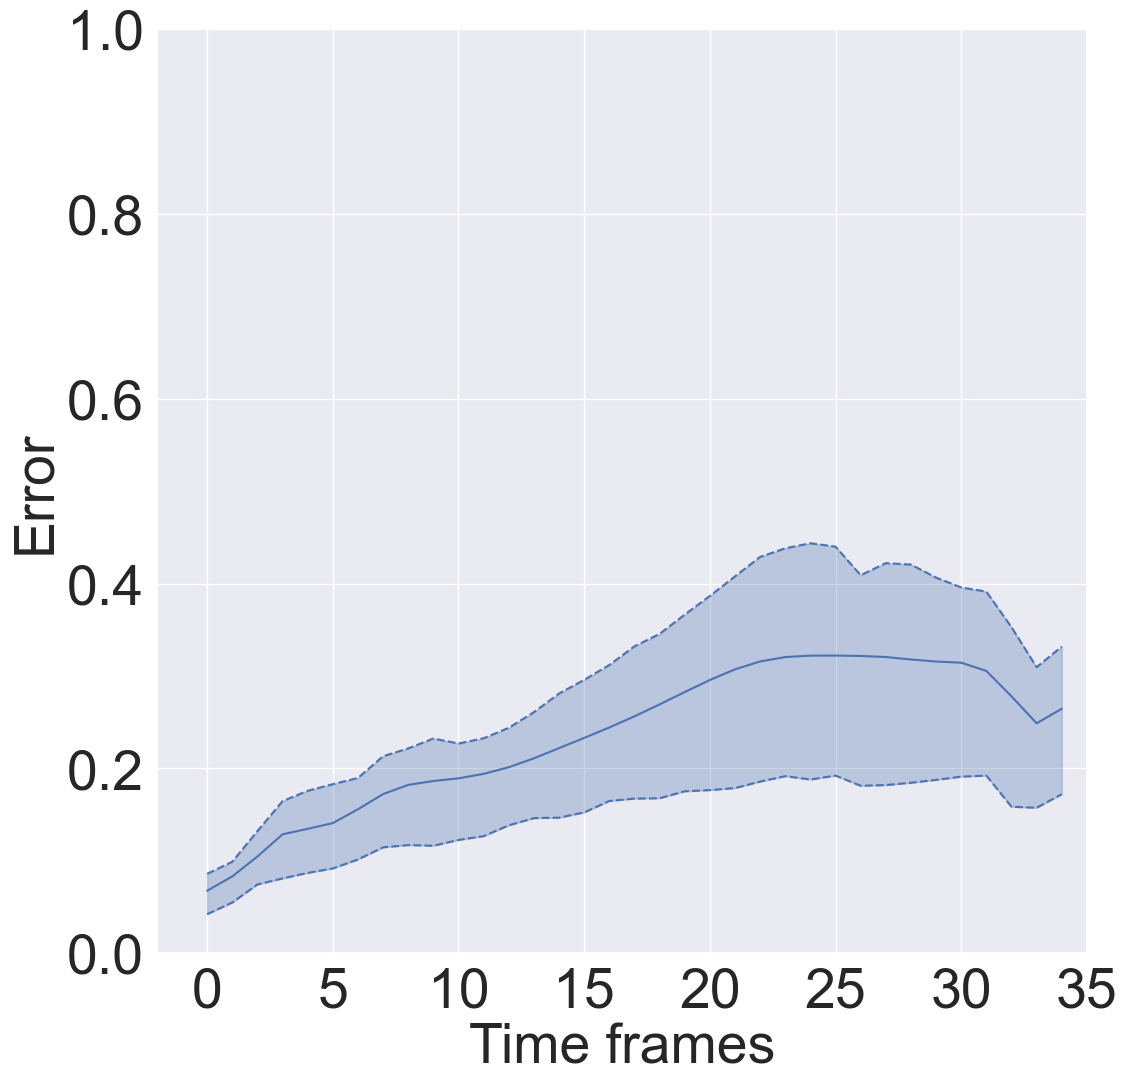

In [31]:
error_to_use = all_error_test
mean_to_use = mean_error_to_plot_test
q25_error = []
q75_error = []

for i in range(dataset.n_frames):
    q25_error.append(np.percentile(error_to_use[i], 25))
    q75_error.append(np.percentile(error_to_use[i], 75))

q25_error = jnp.array(q25_error)
q75_error = jnp.array(q75_error)

fig, ax = plt.subplots(figsize= (12, 12))
ax.plot(time_line, mean_to_use, color = "b")
ax.plot(time_line, q25_error, linestyle = "--", color = "b")
ax.plot(time_line, q75_error, linestyle = "--", color = "b")
ax.fill_between(time_line, q25_error, q75_error, alpha=0.3, color = "b")
plt.ylabel("Error", fontsize = 40)
plt.xlabel("Time frames", fontsize = 40)
plt.xticks(fontsize=40)  # for x-axis
plt.yticks(fontsize=40)
plt.xlim(-2, 35)

plt.ylim(0, 0.6)
plt.yticks(np.arange(0.0, 1.2, 0.2))
plt.savefig("S6_data/S6_80/Errors/Average_Error.png")

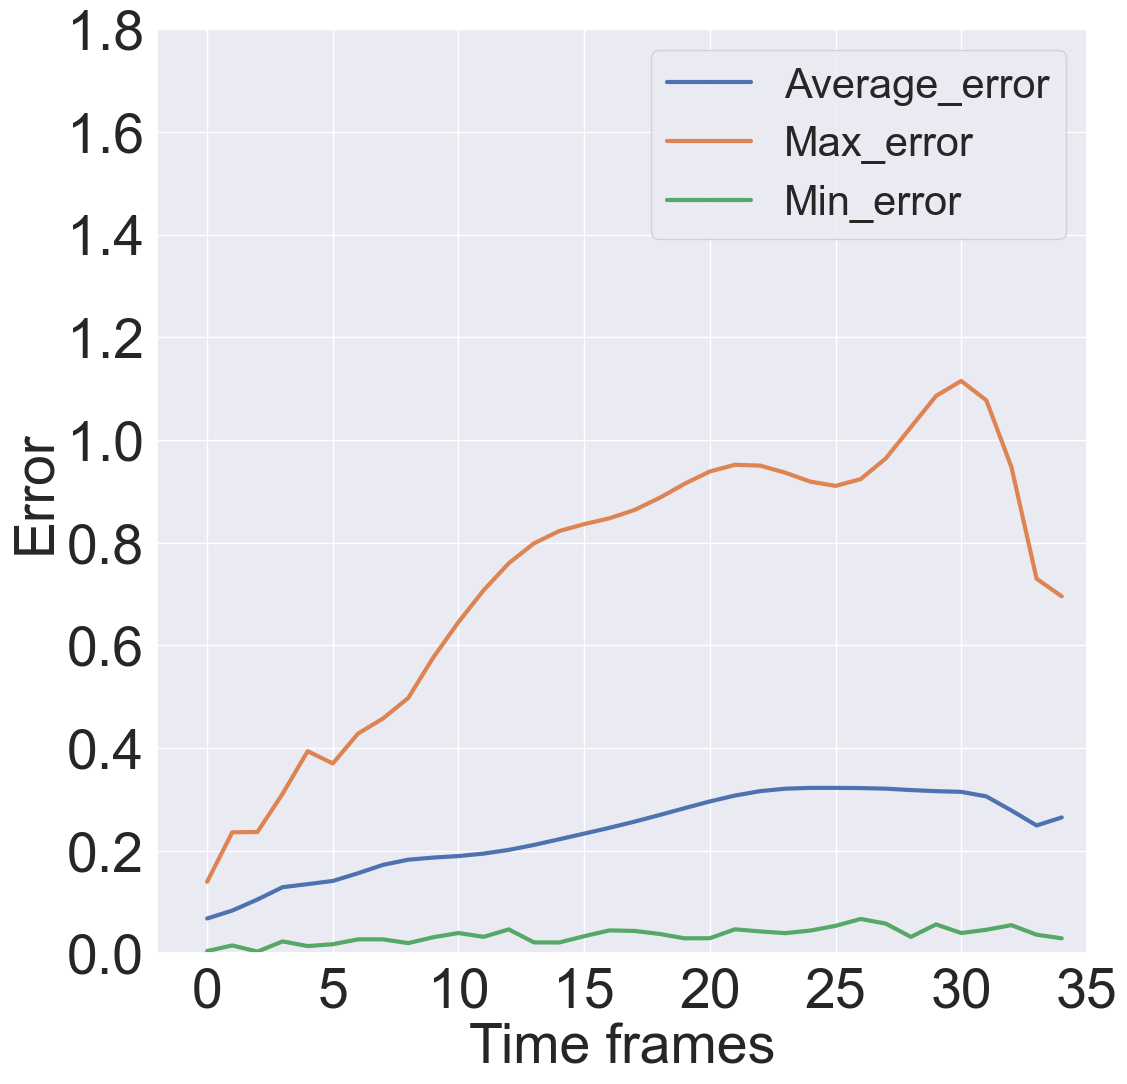

In [32]:
fig = plt.figure(figsize=(12, 12))
mean_to_use = mean_error_to_plot_test
max_to_use = max_error_to_plot_test
min_to_use = min_error_to_plot_test
plt.plot(time_line, mean_to_use, label = "Average_error", linewidth = 3.0)
plt.plot(time_line, max_to_use, label = "Max_error", linewidth = 3.0)
plt.plot(time_line, min_to_use, label = "Min_error", linewidth = 3.0)
plt.ylabel("Error", fontsize = 40)
plt.xlabel("Time frames", fontsize = 40)
plt.xticks(fontsize=40)  # for x-axis
plt.yticks(fontsize=40)
plt.xlim(-2, 35)
plt.ylim(0, 0.6)
plt.yticks(np.arange(0.0, 2.0, 0.2))
plt.legend(fontsize = 30)
plt.savefig("S6_data/S6_80/Errors/All_errors.png")

In [33]:
print("Max average error:", mean_error_to_plot_test.max())
print("Max max error:", max_error_to_plot_test.max())
print("Max min error:", min_error_to_plot_test.max())

Max average error: 0.3221526284897177
Max max error: 1.1148771613873978
Max min error: 0.06679663969712105


In [34]:
E_ff = []
E_cc = []
E_rr = []
E_ll = []

for i in range(dataset.n_frames):
    i_t = i/dataset.n_frames
    e_ff = model.E(loss_params, Bs, jnp.concatenate((eigfuncs[jnp.ravel(connectivity_dense)], jnp.ones((eigfuncs[jnp.ravel(connectivity_dense)].shape[0],1))*i_t), axis = 1), fxf_invivo_fibers)
    e_cc = model.E(loss_params, Bs, jnp.concatenate((eigfuncs[jnp.ravel(connectivity_dense)], jnp.ones((eigfuncs[jnp.ravel(connectivity_dense)].shape[0],1))*i_t), axis = 1), cxc_invivo_fibers)
    e_rr = model.E(loss_params, Bs, jnp.concatenate((eigfuncs[jnp.ravel(connectivity_dense)], jnp.ones((eigfuncs[jnp.ravel(connectivity_dense)].shape[0],1))*i_t), axis = 1), rxr_invivo_fibers)
    e_ll = model.E(loss_params, Bs, jnp.concatenate((eigfuncs[jnp.ravel(connectivity_dense)], jnp.ones((eigfuncs[jnp.ravel(connectivity_dense)].shape[0],1))*i_t), axis = 1), lxl_invivo_fibers)
    
    frame_to_plot = np.ones_like(e_ff)*(i)
    E_ff.append(e_ff)
    E_cc.append(e_cc)
    E_rr.append(e_rr)
    E_ll.append(e_ll)

E_ff = jnp.array(E_ff)
E_cc = jnp.array(E_cc)
E_rr = jnp.array(E_rr)
E_ll = jnp.array(E_ll)

np.savetxt('S6_data/S6_80/Eff.csv', E_ff)
np.savetxt('S6_data/S6_80/Ell.csv', E_ll)
np.savetxt('S6_data/S6_80/Err.csv', E_rr)
np.savetxt('S6_data/S6_80/Ecc.csv', E_cc)

E_ff_paper = jnp.median(E_ff, axis = 1)
E_cc_paper = jnp.median(E_cc, axis = 1)
E_rr_paper = jnp.median(E_rr, axis = 1)
E_ll_paper = jnp.median(E_ll, axis = 1)

In [35]:
print("Minimum median E_ff:", E_ff_paper.min())

Minimum median E_ff: -0.12870711840153487


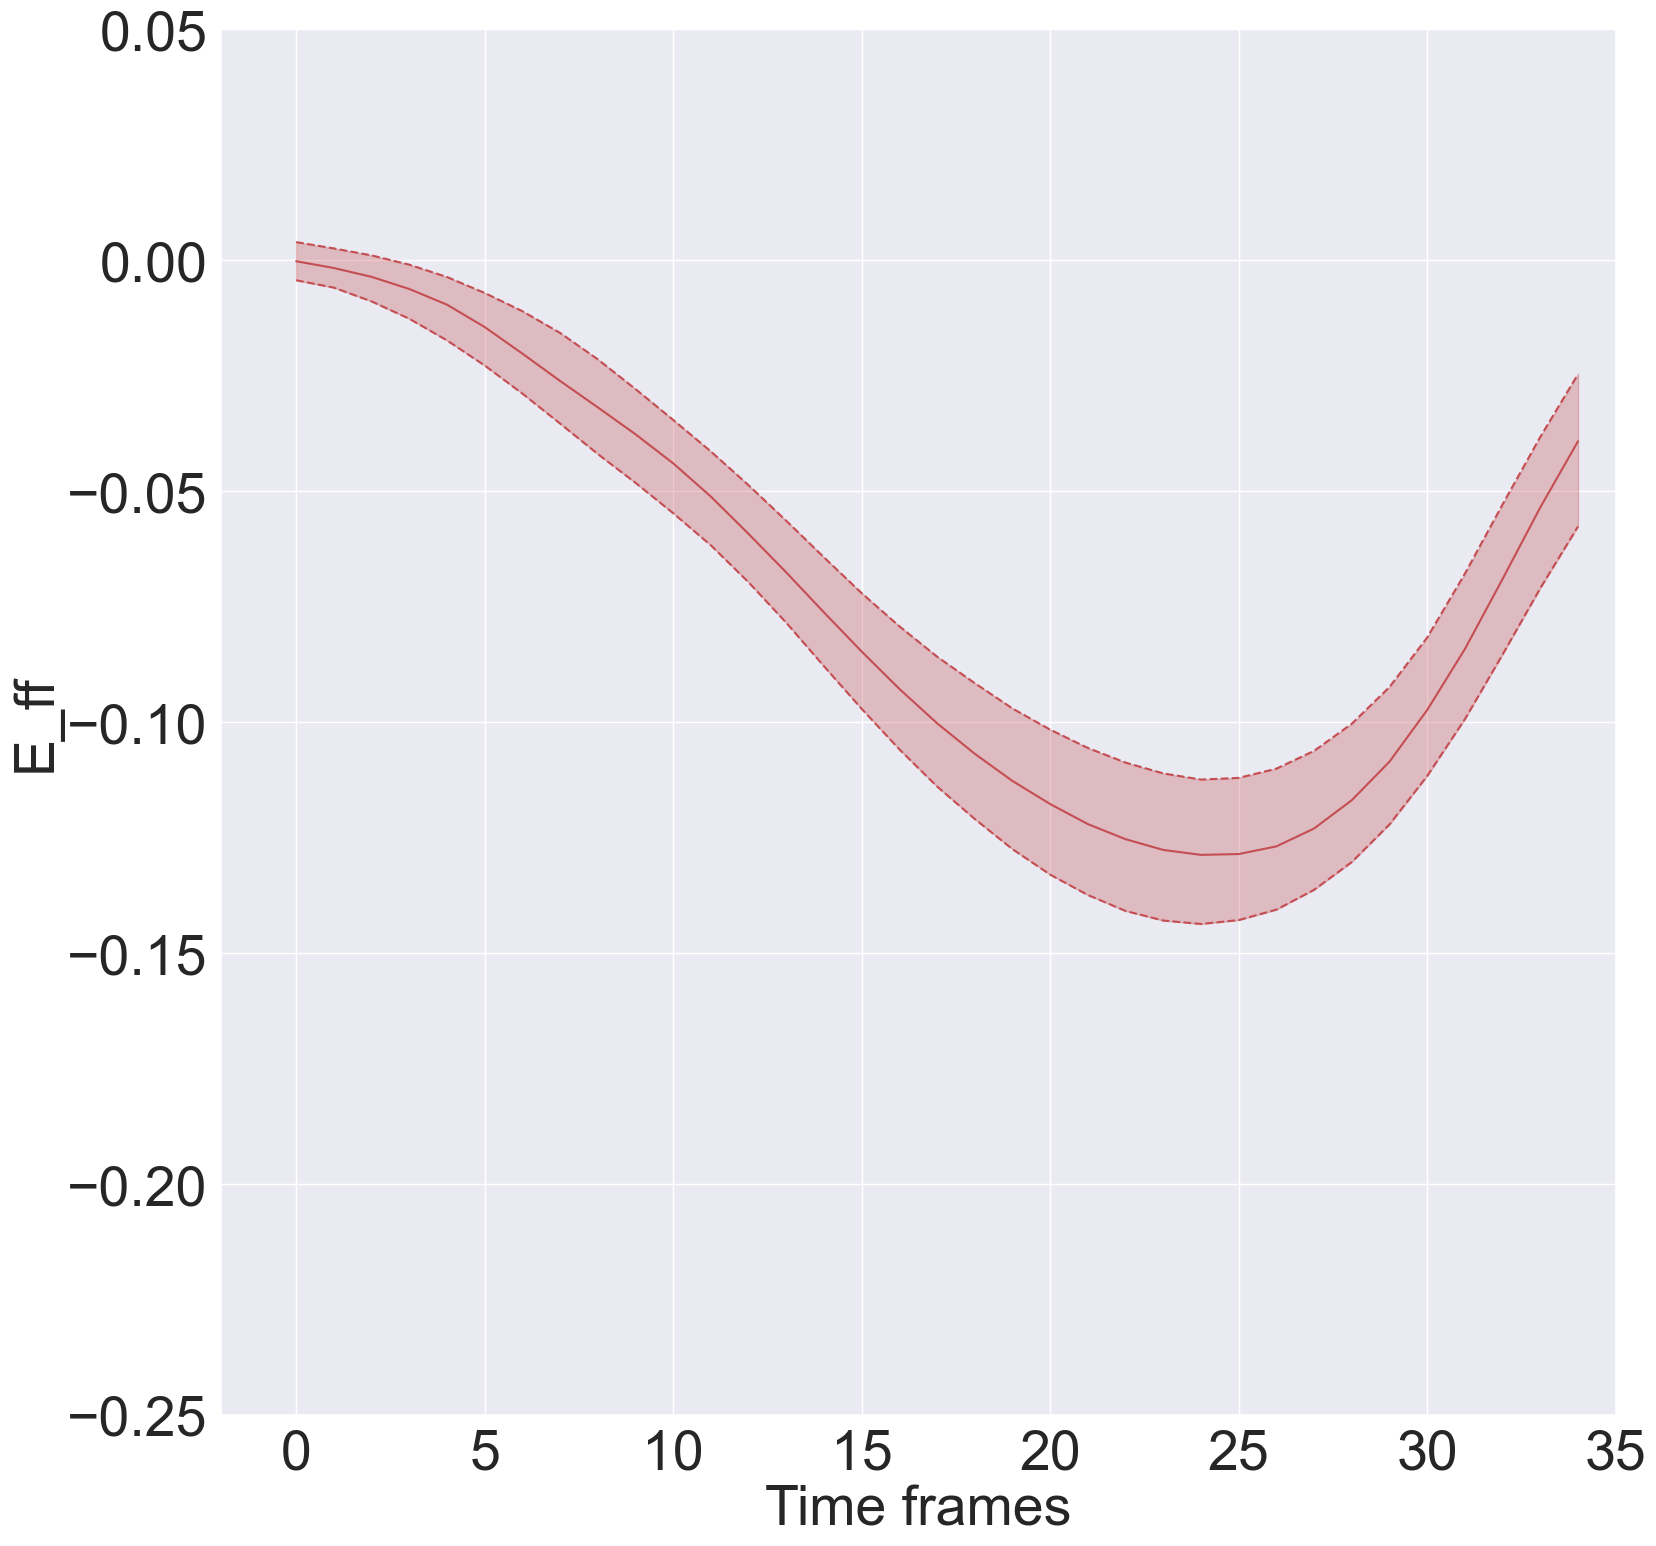

In [36]:
q25 = []
q75 = []

for i in range(dataset.n_frames):
    q25.append(np.percentile(E_ff[i], 25))
    q75.append(np.percentile(E_ff[i], 75))

q25 = jnp.array(q25)
q75 = jnp.array(q75)


fig, ax = plt.subplots(figsize= (18, 18))
ax.plot(time_line, E_ff_paper, color = "r")
ax.plot(time_line, q25, linestyle = "--", color = "r")
ax.plot(time_line, q75, linestyle = "--", color = "r")
ax.fill_between(time_line, q25, q75, alpha=0.3, color = "r")
plt.ylabel("E_ff", fontsize = 40)
plt.xlabel("Time frames", fontsize = 40)
plt.xticks(fontsize=40)  # for x-axis
plt.yticks(fontsize=40)
plt.xlim(-2, 35)
plt.ylim(-0.25, 0.05)
plt.yticks(np.arange(-0.25, 0.06, 0.05))
plt.savefig("S6_data/S6_80/E_tensors/E_ff.png")

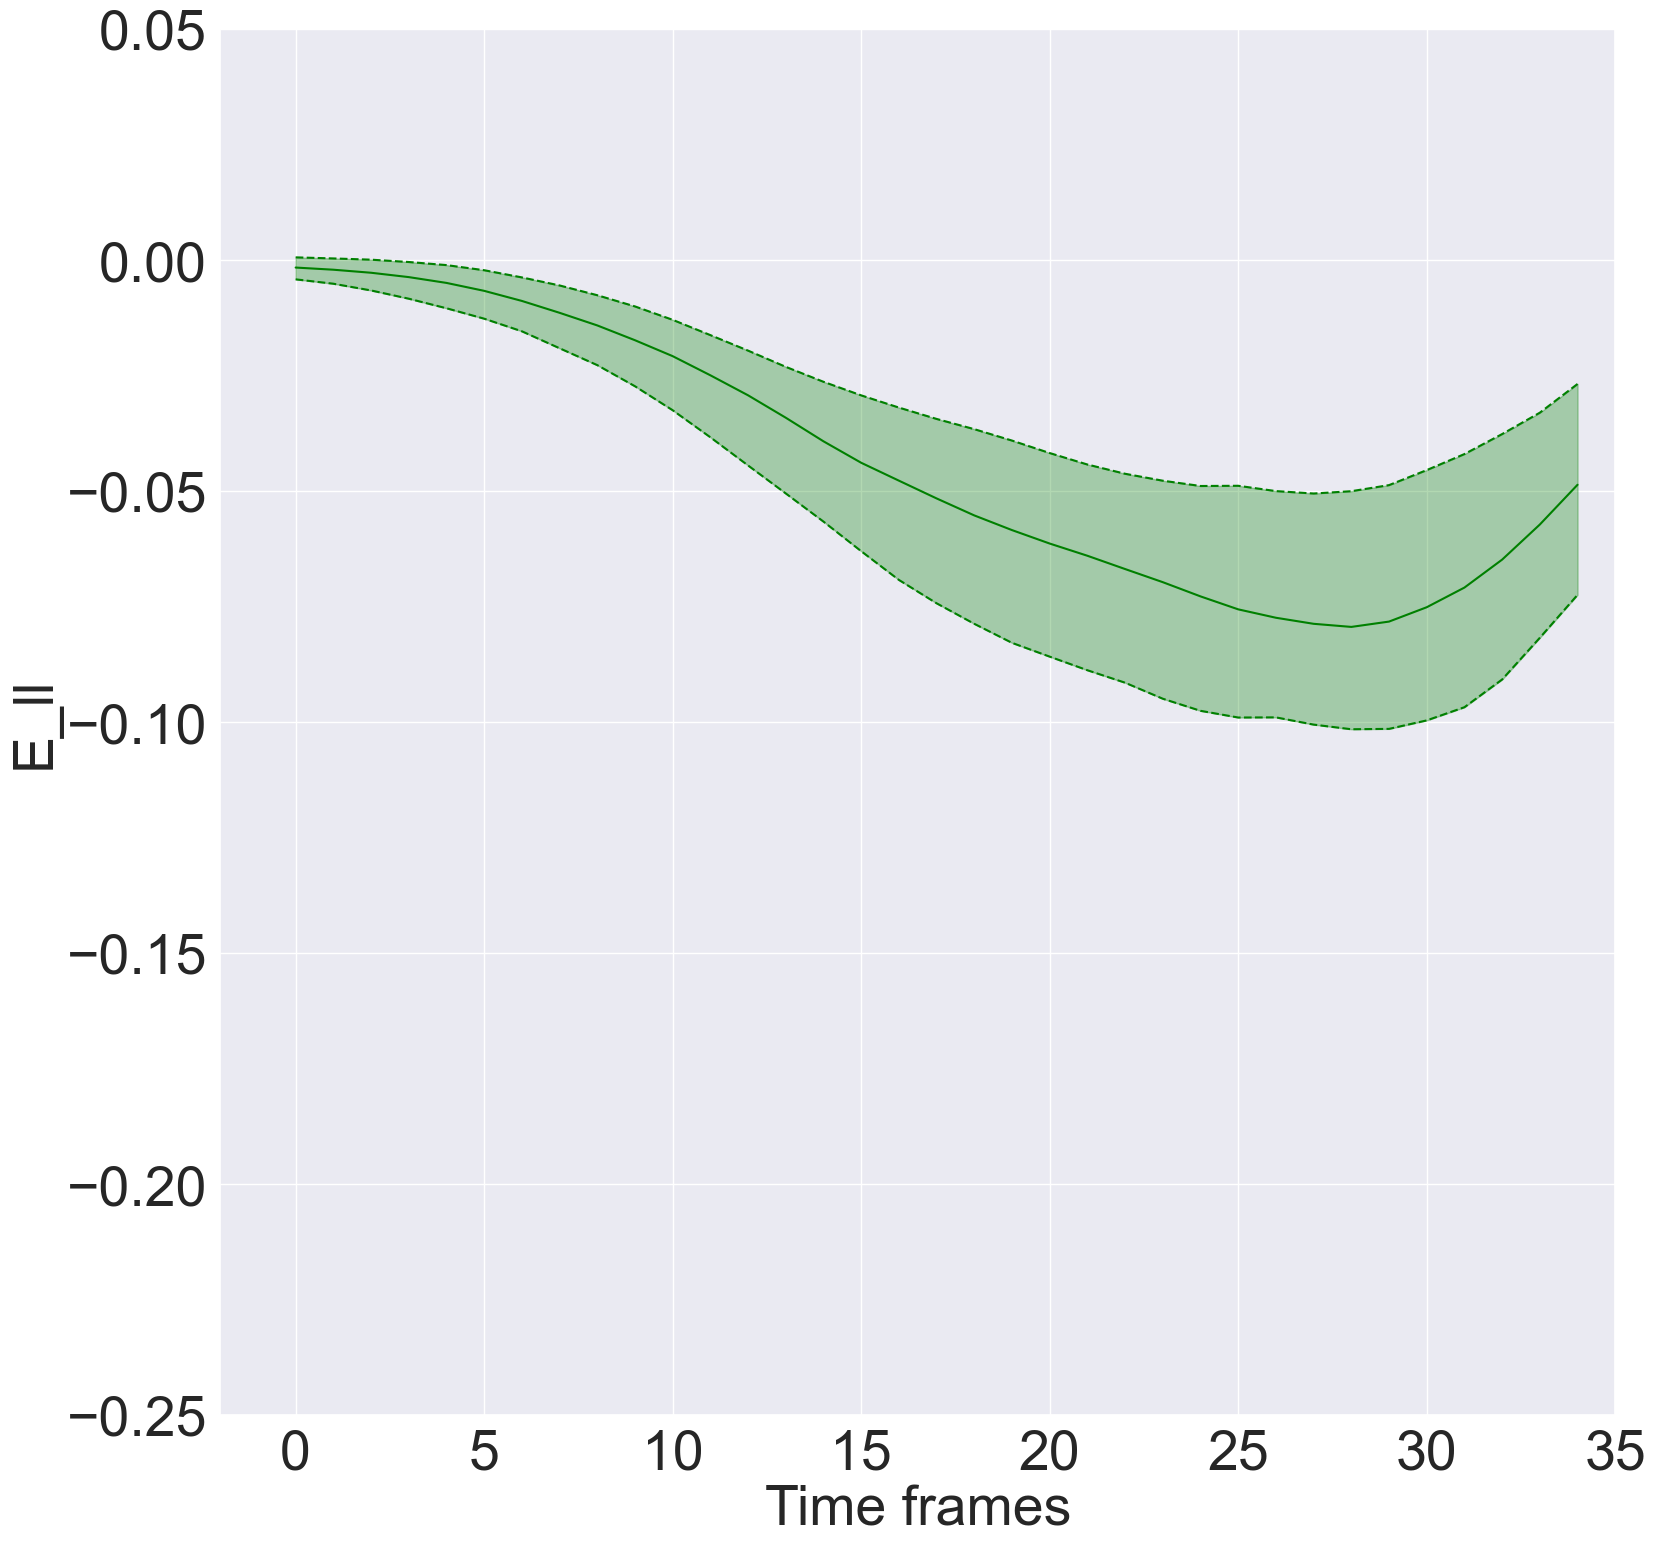

In [37]:
q25 = []
q75 = []

for i in range(dataset.n_frames):
    q25.append(np.percentile(E_ll[i], 25))
    q75.append(np.percentile(E_ll[i], 75))

q25 = jnp.array(q25)
q75 = jnp.array(q75)


fig, ax = plt.subplots(figsize= (18, 18))
ax.plot(time_line, E_ll_paper, color = "green")
ax.plot(time_line, q25, linestyle = "--", color = "green")
ax.plot(time_line, q75, linestyle = "--", color = "green")
ax.fill_between(time_line, q25, q75, alpha=0.3, color = "green")
plt.ylabel("E_ll", fontsize = 40)
plt.xlabel("Time frames", fontsize = 40)
plt.xticks(fontsize=40)  # for x-axis
plt.yticks(fontsize=40)
plt.xlim(-2, 35)
plt.ylim(-0.25, 0.01)
plt.yticks(np.arange(-0.25, 0.06, 0.05))
plt.savefig("S6_data/S6_80/E_tensors/E_ll.png")

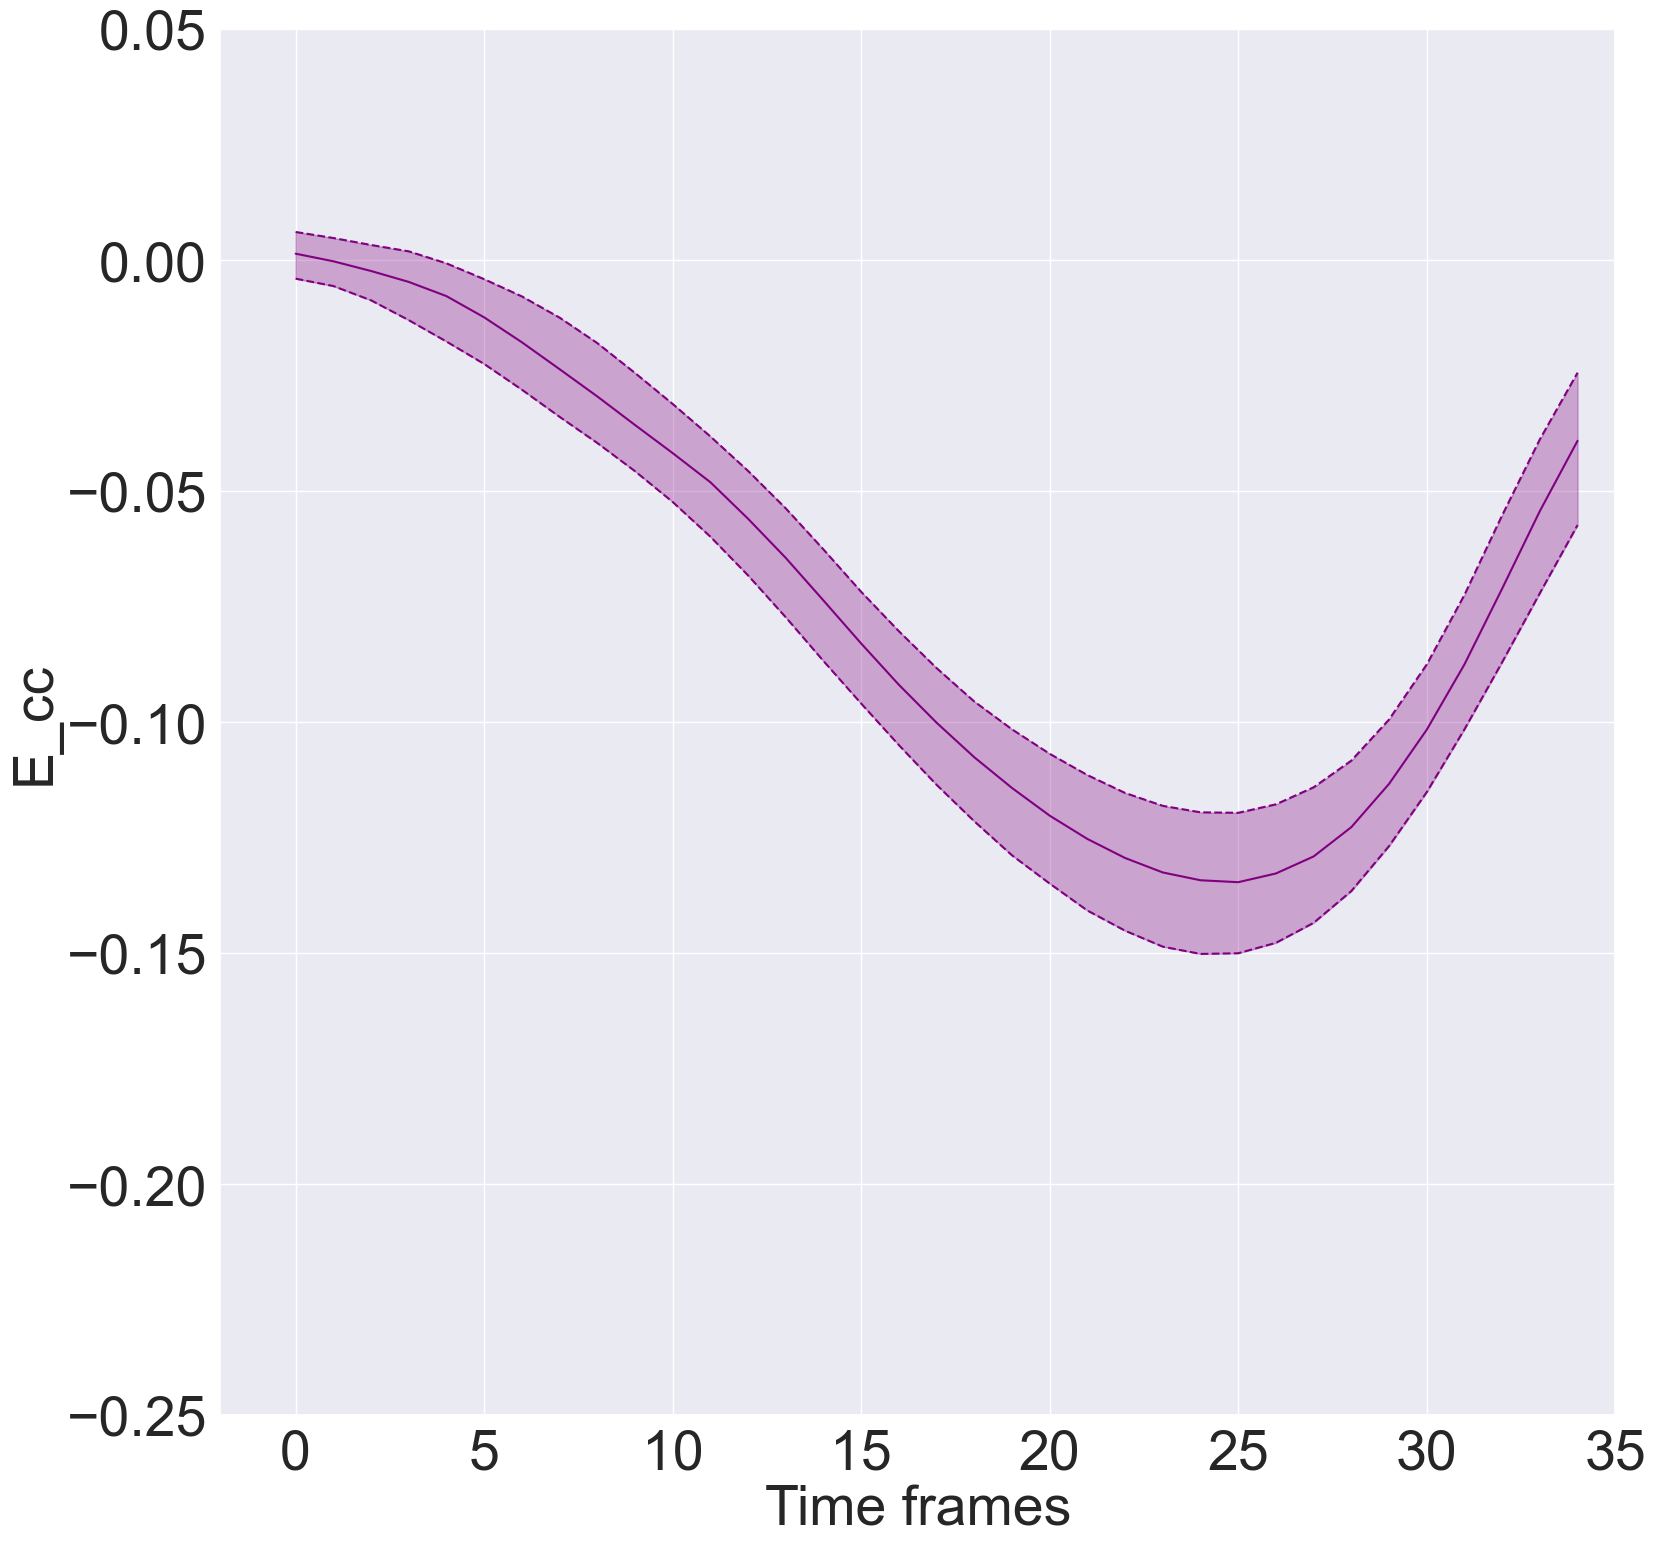

In [38]:
q25 = []
q75 = []

for i in range(dataset.n_frames):
    q25.append(np.percentile(E_cc[i], 25))
    q75.append(np.percentile(E_cc[i], 75))

q25 = jnp.array(q25)
q75 = jnp.array(q75)


fig, ax = plt.subplots(figsize= (18, 18))
ax.plot(time_line, E_cc_paper, color = "purple")
ax.plot(time_line, q25, linestyle = "--", color = "purple")
ax.plot(time_line, q75, linestyle = "--", color = "purple")
ax.fill_between(time_line, q25, q75, alpha=0.3, color = "purple")
plt.ylabel("E_cc", fontsize = 40)
plt.xlabel("Time frames", fontsize = 40)
plt.xticks(fontsize=40)  # for x-axis
plt.yticks(fontsize=40)
plt.xlim(-2, 35)
plt.ylim(-0.25, 0.01)
plt.yticks(np.arange(-0.25, 0.06, 0.05))
plt.savefig("S6_data/S6_80/E_tensors/E_cc.png")

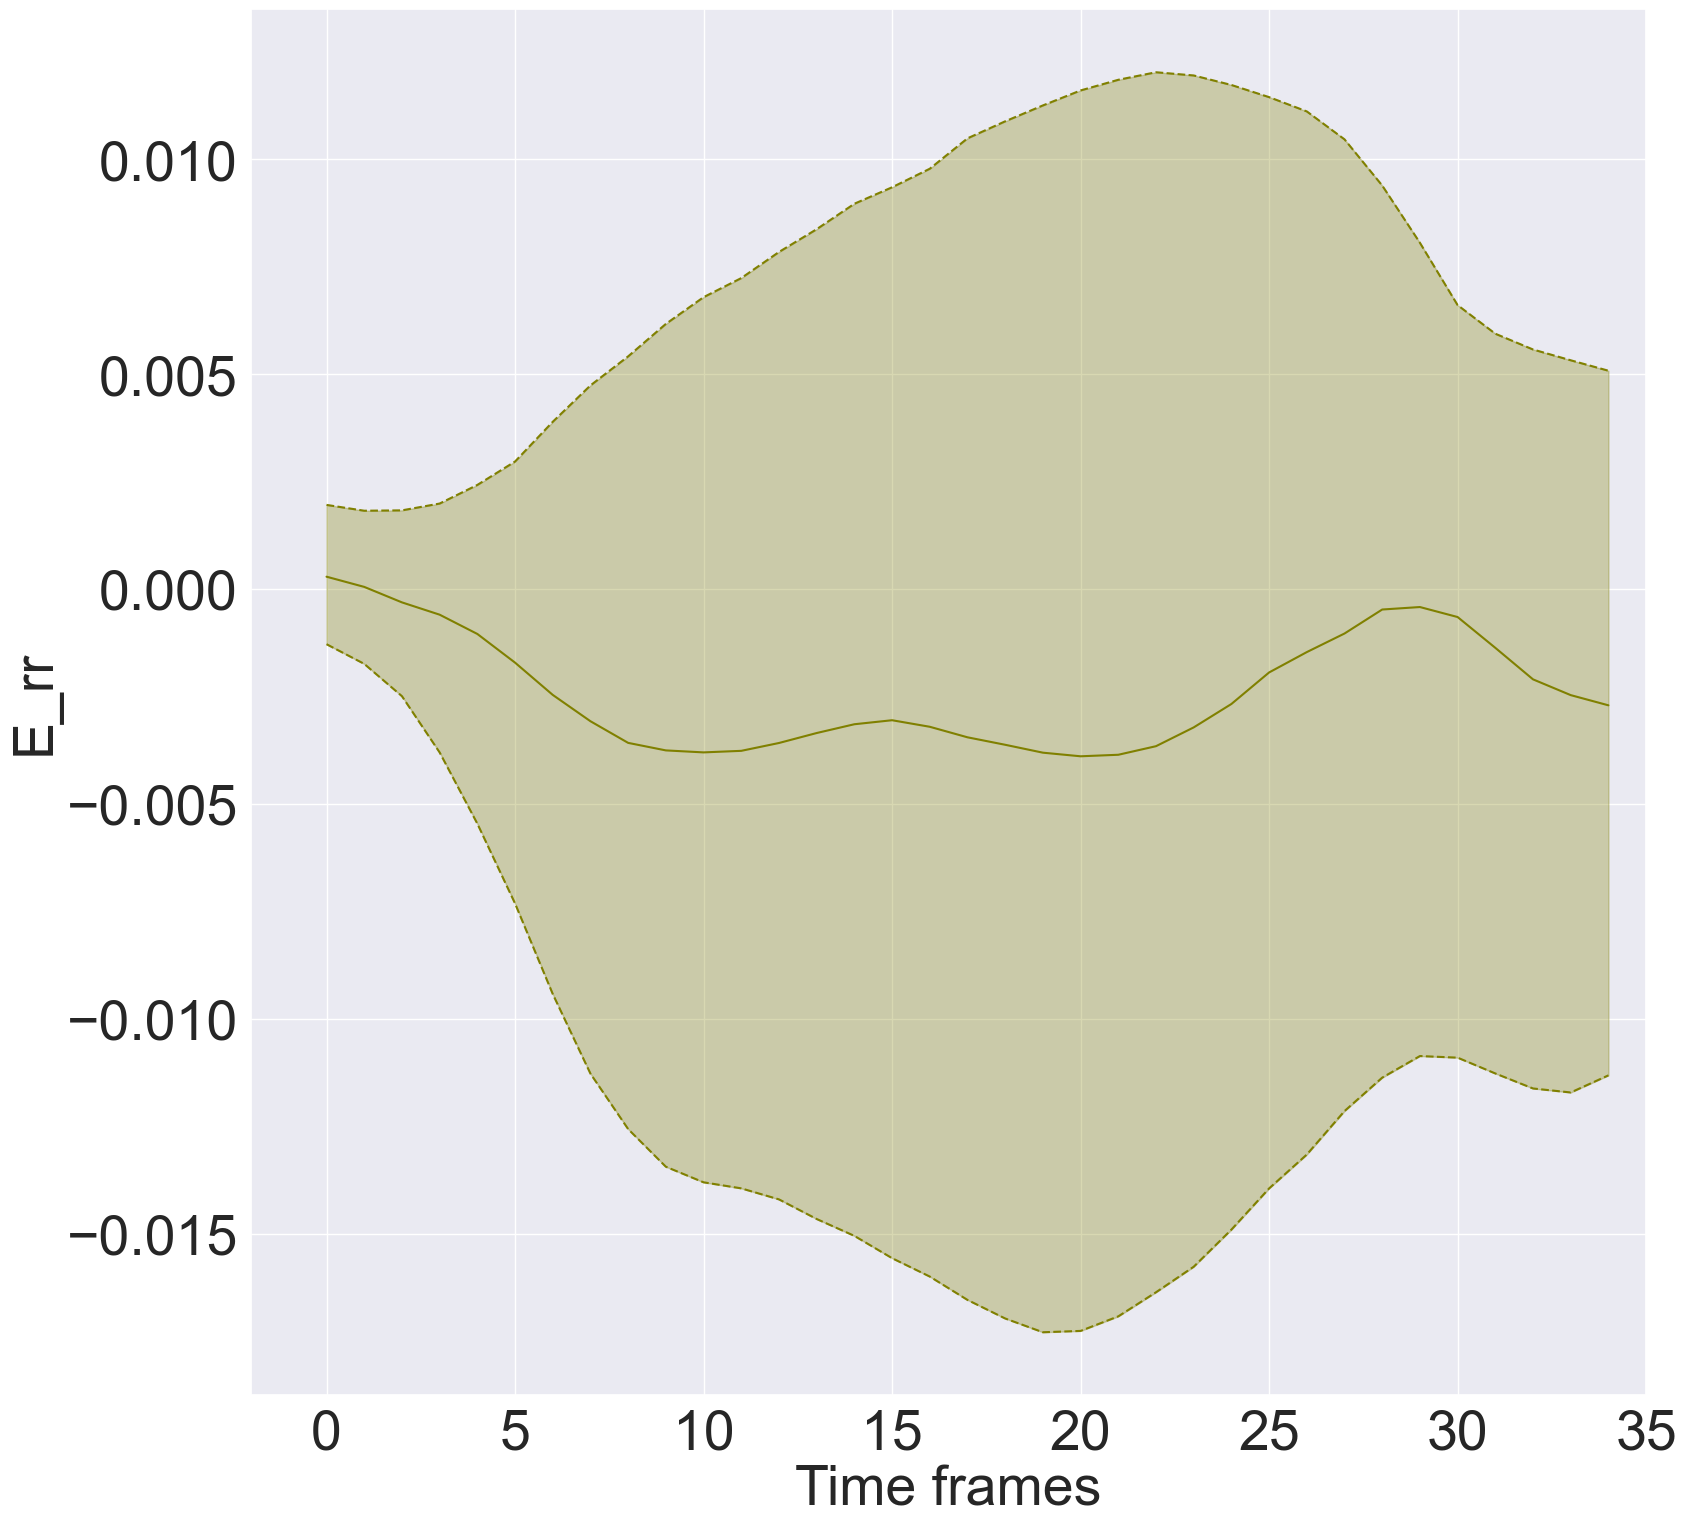

In [39]:
q25 = []
q75 = []

for i in range(dataset.n_frames):
    q25.append(np.percentile(E_rr[i], 25))
    q75.append(np.percentile(E_rr[i], 75))

q25 = jnp.array(q25)
q75 = jnp.array(q75)


fig, ax = plt.subplots(figsize= (18, 18))
ax.plot(time_line, E_rr_paper, color = "olive")
ax.plot(time_line, q25, linestyle = "--", color = "olive")
ax.plot(time_line, q75, linestyle = "--", color = "olive")
ax.fill_between(time_line, q25, q75, alpha=0.3, color = "olive")
plt.ylabel("E_rr", fontsize = 40)
plt.xlabel("Time frames", fontsize = 40)
plt.xticks(fontsize=40)  # for x-axis
plt.yticks(fontsize=40)
plt.xlim(-2, 35)
#plt.ylim(-0.25, 0.01)
#plt.yticks(np.arange(-0.25, 0.0, 0.05))
plt.savefig("S6_data/S6_80/E_tensors/E_rr.png")

In [40]:
np.savetxt('S6_data/S6_80/E_Tensors/E_ff_invivo.csv', E_ff)
np.savetxt('S6_data/S6_80/E_Tensors/E_ff_median_invivo.csv', E_ff_paper)
np.savetxt('S6_data/S6_80/E_Tensors/E_cc_invivo.csv', E_cc)
np.savetxt('S6_data/S6_80/E_Tensors/E_cc_median_invivo.csv', E_cc_paper)
np.savetxt('S6_data/S6_80/E_Tensors/E_rr_invivo.csv', E_rr)
np.savetxt('S6_data/S6_80/E_Tensors/E_rr_median_invivo.csv', E_rr_paper)
np.savetxt('S6_data/S6_80/E_Tensors/E_ll_invivo.csv', E_ll)
np.savetxt('S6_data/S6_80/E_Tensors/E_ll_median_invivo.csv', E_ll_paper)

Most important data is saved in a txt file.

In [41]:
with open("S6_data/S6_80/Information.txt",'w') as f:
    pass

with open("S6_data/S6_80/Information.txt", 'w') as f:
    f.write("DENSE points shape: "+str(points_dense.shape))
    f.write("\nNumber of eigenfunctions: "+str(n_eigs))
    f.write("\nEigenfunctions shape: "+ str(eigfuncs.shape))
    f.write("\nB matrix shape: "+ str(Bs.shape))
    f.write("\nw_u value: "+ str(model.w_u))
    f.write("\nw_r value: "+ str(model.w_r))
    f.write("\nw_theta value: "+ str(model.w_theta))
    f.write("\nNet width: "+ str(n_depth))
    f.write("\nNet depth: "+ str(len(layers)-2))
    f.write("\nBatchsize: "+ str(batch_size))
    f.write("\n---------------------------------------------------------------------------------------------")
    f.write("\nPRELOSS")
    f.write("\n---------------------------------------------------------------------------------------------")
    f.write("\nLearning rate preloss: "+ str(learning_rate))
    f.write("\nNiter preloss: "+ str(n_iter_preloss))
    f.write("\nTime to train preloss: "+ str(int(time_preloss/60))+ " minutos y "+str(round(time_preloss%60))+" segundos")
    f.write("\n---------------------------------------------------------------------------------------------")
    f.write("\nLOSS")
    f.write("\n---------------------------------------------------------------------------------------------")
    f.write("\nLearning rate loss: "+ str(learning_rate1))
    f.write("\nNiter loss: "+ str(n_iter_loss))
    f.write("\nMax average error loss: "+ str(mean_error_to_plot_test.max()))
    f.write("\nMax max error loss: "+ str(max_error_to_plot_test.max()))
    f.write("\nMax min error loss: "+ str(min_error_to_plot_test.max()))
    f.write("\nTime to train loss: "+ str(int(time_loss/60))+ " minutos y "+str(round(time_loss%60))+" segundos")